* CNN by TensorFLow Eager
* High level

In [2]:
import sys
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from sklearn import model_selection, metrics
from tqdm import tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe

In [3]:
tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 1.8.0
Eager execution: True


In [4]:
import urllib
from sklearn.datasets import fetch_mldata

try:
    mnist = fetch_mldata('MNIST original')
except urllib.error.HTTPError as ex:
    from six.moves import urllib
    from scipy.io import loadmat
    import os
    print('Could not download MNIST data from mldata.org, trying alternative...')
    mnist_alternative_url = 'https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat'
    mnist_path = './mnist-original.mat'
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, 'wb') as f:
        content = response.read()
        f.write(content)
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw['data'].T,
        "target": mnist_raw['label'][0],
        "COL_NAMES": ['label', 'data'],
        "DESCR": 'mldata.org dataset: mnist-original',
    }
    print('Success!')

In [5]:
mnist['data'] = mnist['data'].astype(np.float32).reshape(len(mnist['data']), 28, 28, 1) # image data
mnist['data'] /= 255
mnist['target'] = mnist['target'].astype(np.int32) # label data
mnist['data'].shape, mnist['target'].shape

((70000, 28, 28, 1), (70000,))

In [6]:
# train data size : validation data size= 8 : 2
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(mnist['data'], mnist['target'], test_size=0.2)

# ラベルはone-hotベクトルに変換する
#train_y = np.eye(np.max(train_y)+1)[train_y]
#valid_y = np.eye(np.max(valid_y)+1)[valid_y]

train_x.shape, train_y.shape, valid_x.shape, valid_y.shape

((56000, 28, 28, 1), (56000,), (14000, 28, 28, 1), (14000,))

In [9]:
output_size = 10

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(20, (5, 5), activation=tf.nn.relu),
    tf.keras.layers.Conv2D(50, (5, 5), activation=tf.nn.relu),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500, activation=tf.nn.relu),
    tf.keras.layers.Dense(500, activation=tf.nn.relu),
    tf.keras.layers.Dense(output_size, activation=tf.nn.softmax),
])

def lossfun(model, x, y):
    y_pre = model(x)
    y_oh = tf.one_hot(y, depth=output_size, dtype=tf.float32)
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_oh, logits=y_pre))
    return cross_entropy

def grad(model, x, y):
    with tf.GradientTape() as tape:
        loss = lossfun(model, x, y)
    return tape.gradient(loss, model.variables)

optimizer = tf.train.AdamOptimizer()

In [10]:
epoch_num = 5
batch_size = 1000

train_x_tf = tf.convert_to_tensor(train_x, dtype=tf.float32)
train_y_tf = tf.convert_to_tensor(train_y, dtype=tf.int32)
valid_x_tf = tf.convert_to_tensor(valid_x, dtype=tf.float32)
valid_y_tf = tf.convert_to_tensor(valid_y, dtype=tf.int32)

for epoch in tqdm(range(epoch_num), file=sys.stdout):
    
    n = train_x_tf.shape[0]
    n = n.value
    perm = np.random.permutation(n)
    
    for i in range(0, n, batch_size):

        batch_x = tf.gather(train_x_tf, perm[i:i+batch_size])
        batch_y = tf.gather(train_y_tf, perm[i:i+batch_size])

        grads = grad(model, batch_x, batch_y)
        optimizer.apply_gradients(zip(grads, model.variables), global_step=tf.train.get_or_create_global_step())

    train_loss = lossfun(model, train_x_tf, train_y_tf)
    correct_prediction = tf.equal(tf.argmax(model(train_x_tf), axis=1, output_type=tf.int32), train_y_tf)
    train_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    valid_loss = lossfun(model, valid_x_tf, valid_y_tf)
    correct_prediction = tf.equal(tf.argmax(model(valid_x_tf), axis=1, output_type=tf.int32), valid_y_tf)
    valid_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
    if (epoch+1)%1 == 0:
        tqdm.write('epoch:\t{}\ttrain/loss:\t{:.5f}\tvalid/loss:\t{:.5f}\ttrain/accuracy:\t{:.5f}\tvalid/accuracy:\t{:.5f}'.format(
            epoch+1, train_loss, valid_loss, train_acc, valid_acc)
        )

epoch:	1	train/loss:	1.53761	valid/loss:	1.53892	train/accuracy:	0.92557	valid/accuracy:	0.92314
epoch:	2	train/loss:	1.48837	valid/loss:	1.49182	train/accuracy:	0.97371	valid/accuracy:	0.97029
epoch:	3	train/loss:	1.48066	valid/loss:	1.48491	train/accuracy:	0.98150	valid/accuracy:	0.97693
epoch:	4	train/loss:	1.47476	valid/loss:	1.47896	train/accuracy:	0.98702	valid/accuracy:	0.98314
epoch:	5	train/loss:	1.47420	valid/loss:	1.47815	train/accuracy:	0.98782	valid/accuracy:	0.98336
100%|██████████| 5/5 [00:16<00:00,  3.36s/it]


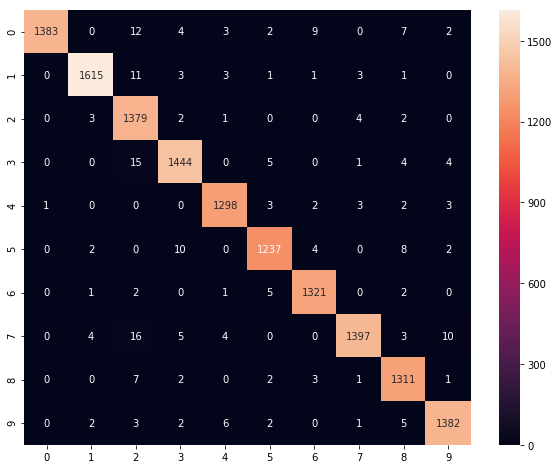

In [14]:
preds = np.argmax(model.predict(valid_x), axis=1)

cm = metrics.confusion_matrix(preds, valid_y)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

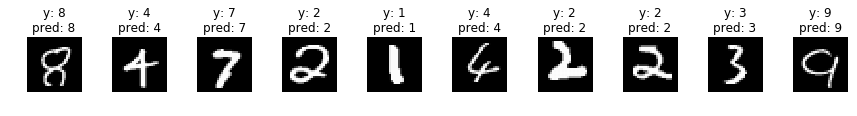

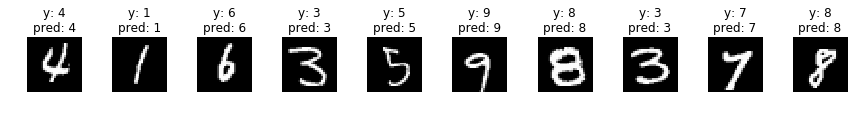

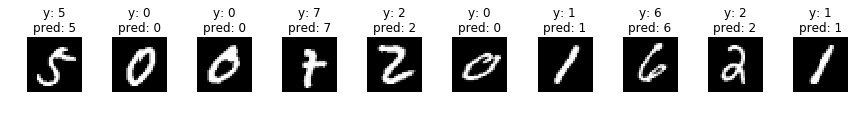

In [15]:
indices = np.random.choice(len(valid_x), 30)

for i, idx in enumerate(indices):
    
    if i%10 == 0:
        fig, axs = plt.subplots(ncols=10, figsize=(15,1))
    
    x = valid_x[idx]
    y = valid_y[idx]
    
    x_img = x.reshape(28, 28)
    x = x[np.newaxis]
    
    p = np.argmax(model.predict(x), axis=1)[0]

    axs[i%10].imshow(x_img, cmap='gray')
    title = 'y: {}'.format(y) + '\n' + 'pred: {}'.format(p)
    axs[i%10].set_title(title)
    axs[i%10].axis('off')

plt.show()

In [16]:
!python --version

Python 3.6.3


In [17]:
!pip freeze

absl-py==0.2.0
astor==0.6.2
backcall==0.1.0
bleach==1.5.0
boto==2.49.0
boto3==1.7.73
botocore==1.10.73
bz2file==0.98
certifi==2018.4.16
chainer==4.0.0
chainercv==0.10.0
chardet==3.0.4
cntk-gpu==2.5.1
cupy==4.0.0
cycler==0.10.0
Cython==0.28.2
decorator==4.3.0
dm-sonnet==1.20
docutils==0.14
edward==1.3.5
entrypoints==0.2.3
fastrlock==0.3
filelock==3.0.4
future==0.16.0
gast==0.2.0
gensim==3.5.0
graphviz==0.8.3
grpcio==1.11.0
h5py==2.7.1
html5lib==0.9999999
idna==2.6
ipykernel==4.8.2
ipython==6.3.1
ipython-genutils==0.2.0
ipywidgets==7.2.1
jedi==0.12.0
Jinja2==2.10
jmespath==0.9.3
jsonschema==2.6.0
jupyter==1.0.0
jupyter-client==5.2.3
jupyter-console==5.2.0
jupyter-core==4.4.0
Keras==2.1.6
kiwisolver==1.0.1
Lasagne==0.2.dev1
leveldb==0.194
Mako==1.0.7
Markdown==2.6.11
MarkupSafe==1.0
matplotlib==2.2.2
mecab-python3==0.7
mistune==0.8.3
mxnet-cu90==1.1.0.post0
nbconvert==5.3.1
nbformat==4.4.0
networkx==2.1
nose==1.3.7
notebook==5.4.1
numpy==1.14.3
pandas==0.22.0
pandocfilters==1.4.2
parso==0

In [18]:
!cat /proc/driver/nvidia/version

NVRM version: NVIDIA UNIX x86_64 Kernel Module  384.111  Tue Dec 19 23:51:45 PST 2017
GCC version:  gcc version 5.4.0 20160609 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 


In [19]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:03_CDT_2017
Cuda compilation tools, release 9.0, V9.0.176
